# Univariate Probabilistic Linear Regression

This notebook was adapted from various sources, specially from google's tutorial, Coursera course, and the book Probabilistic Deep Learning from Manning.



In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [2]:
tfd = tfp.distributions
tfb = tfp.bijectors

sns.set()

In [3]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

# Synthetic Dataset

In [4]:
def syn_dataset(n=150, n_tst=150,beta=2):
    # to allow for reproducibility 
    np.random.seed(43)
    # We're making the picking the input features randomly.
    x = np.random.rand(n)
    
    #Let's make the errors heterosckedastic(monotonically)
    eps = np.sqrt(x)*np.random.randn(n)
    
    y = (beta*x)+ eps
    x = x[:, np.newaxis]
    
    # we're making the test inputs to be deterministic, probably different from the 
    # training input features
    x_tst = np.linspace(np.min(x),np.max(x), num=n_tst).astype(np.float32)
    x_tst = x_tst[:, np.newaxis]
    return y, x, x_tst

y_syn_ds, x_syn_ds, x_tst_syn_ds = syn_dataset()

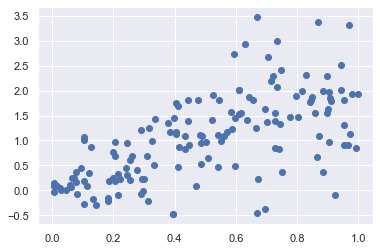

In [5]:
plt.scatter(x_syn_ds,y_syn_ds)
plt.show()

# Building the model for Synth DS

Our data will have the following shape

In [6]:
x_tst_syn_ds.shape

(150, 1)

So, we're going to build an initial Dense layer with input_shape = (1,), and output shape equal to the number of parameters we'll be estimating. In our case, we'll estimate the mean and variance.

In [7]:
# Build model.
model_syn_ds= tf.keras.Sequential([
    tf.keras.layers.Dense(2, input_shape=(1,)),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[:,:1], 
                                                       scale=1e-5+tf.math.softplus(t[:, 1:])
                                # 1e-5+tf.math.softplus() to make sure scale is positive
                                                      ),
                                  convert_to_tensor_fn=tfd.Distribution.sample,
                                  name="Distribution")])

Let's dissect a little the code above...

In [8]:
input_trial=np.array([[0],[2]]) # a smaller batched input

In [9]:
output_from_dense=tf.keras.layers.Dense(2, input_shape=(1,))(input_trial)
output_from_dense

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 0.       ,  0.       ],
       [-2.03833  , -1.6972394]], dtype=float32)>

In [10]:
print(output_from_dense[:,:1])
# the first in each output will be an estimate for the loc parameter
# shape=(2,1) a batch 2 for a scalar parameter (and distribution)
print(output_from_dense[:,1:])
# the second an estimate for the scale

# output_from_dense[:,0] wouldn't match the correct shape that we need for batched data
# and a tfd.Normal distribution
# shape=(2,) would behave as vector parameter (possibly for a vector distribution) 

tf.Tensor(
[[ 0.     ]
 [-2.03833]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[ 0.       ]
 [-1.6972394]], shape=(2, 1), dtype=float32)


Let's now compile the model

In [11]:
# compiling the model
model_syn_ds.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)

In [12]:
model_syn_ds.summary()

model_syn_ds.fit(x_syn_ds, y_syn_ds, epochs=1000, verbose=False);

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 4         
                                                                 
 Distribution (DistributionL  ((None, 1),              0         
 ambda)                       (None, 1))                         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [13]:
try_point=np.array([[0]])
for _ in range(5):
    print(model_syn_ds.predict(try_point))

[[0.6091666]]
[[0.04987247]]
[[0.21154436]]
[[-0.39124072]]
[[-0.509355]]


Notice that whenever I run my model on a constant, it will always predict a different value. 
This is the main difference between probabilistic programming and deterministic programming.

We now have a model which acts like a distribution!

In [14]:
model_syn_ds.weights

[<tf.Variable 'dense/kernel:0' shape=(1, 2) dtype=float32, numpy=array([[2.0617557, 1.7096789]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(2,) dtype=float32, numpy=array([ 0.01879646, -1.0201259 ], dtype=float32)>]

In [15]:
# Do inference.
yhat_syn_ds = model_syn_ds(x_tst_syn_ds)

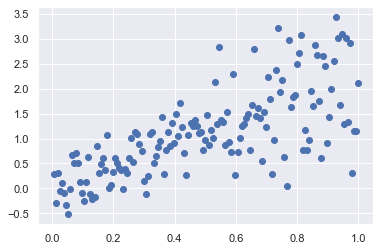

In [16]:
plt.scatter(x_tst_syn_ds,yhat_syn_ds.sample())
plt.show()

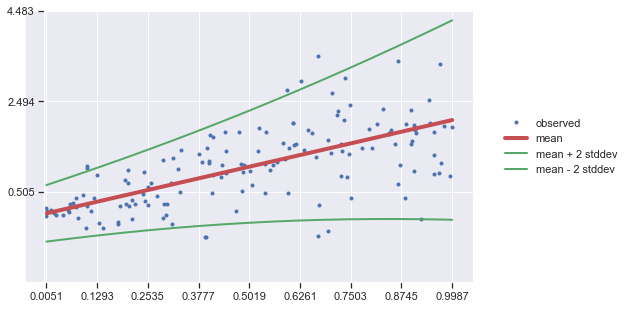

In [17]:
def plot_save_fig(yhat_syn_ds,x_tst_syn_ds,x_syn_ds, y_syn_ds,fig_name="Fig"):
    plt.figure(figsize=[8, 5])  # inches
    plt.plot(x_syn_ds, y_syn_ds, 'b.', label='observed');
    # y_syn_ds, x_syn_ds, x_tst_syn_ds

    m = yhat_syn_ds.mean()
    s = yhat_syn_ds.stddev()

    plt.plot(x_tst_syn_ds, m, 'r', linewidth=4, label='mean');
    plt.plot(x_tst_syn_ds, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev');
    plt.plot(x_tst_syn_ds, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev');


    y_range=[np.min(y_syn_ds)-1,np.max(y_syn_ds)+1]
    plt.ylim(*y_range);
    plt.yticks(np.linspace(*y_range, 4)[1:]);

    x_range=[np.min(x_syn_ds),np.max(x_syn_ds)]
    plt.xticks(np.linspace(*x_range, num=9));

    ax=plt.gca();
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data', 0))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['left'].set_smart_bounds(True)
    #ax.spines['bottom'].set_smart_bounds(True)
    plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

    plt.savefig('./Figures/'+ fig_name, bbox_inches='tight', dpi=300)
    
plot_save_fig(yhat_syn_ds,x_tst_syn_ds,x_syn_ds, y_syn_ds)

# A non-monotonic heteroskedastic error

In [18]:
def syn_dataset2(n=150, n_tst=150,beta=2):
    # to allow for reproducibility 
    np.random.seed(43)
    # We're making the picking the input features randomly.
    x = np.random.rand(n)
    
    #Let's make the errors heterosckedastic(non-monotonic)
    eps = np.sqrt((x-0.5)**2)*np.random.randn(n)
    
    y = (beta*x)+ eps
    x = x[:, np.newaxis]
    
    # we're making the test inputs to be deterministic, probably different from the 
    # training input features
    x_tst = np.linspace(np.min(x),np.max(x), num=n_tst).astype(np.float32)
    x_tst = x_tst[:, np.newaxis]
    return y, x, x_tst

y_syn_ds2, x_syn_ds2, x_tst_syn_ds2 = syn_dataset2()

In [19]:
# compiling the model
model_syn_ds.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model_syn_ds.fit(x_syn_ds2, y_syn_ds2, epochs=1000, verbose=False);

In [20]:
yhat_syn_ds2 = model_syn_ds(x_tst_syn_ds2)

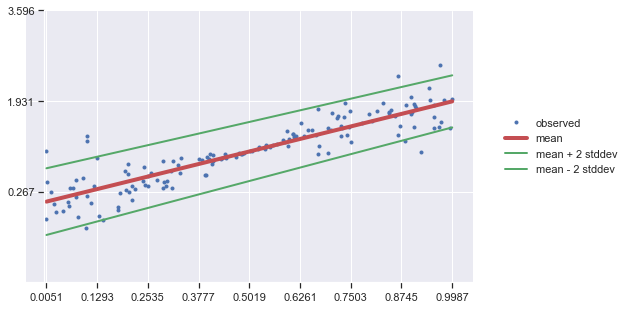

In [21]:
plot_save_fig(yhat_syn_ds2,x_tst_syn_ds2,x_syn_ds2, y_syn_ds2,"Fig2")
# Our std-dev estimator cannot model a non-monotonic evolution of the std-dev

Notice that our std-dev estimator cannot model a non-monotonic evolution of the std-dev.

One way to improve this is to add hidden layers to estimate the std-dev

In [22]:
inputs = tf.keras.layers.Input(shape=(1,)) 
out1 = tf.keras.layers.Dense(1)(inputs) 
hidden1 = tf.keras.layers.Dense(30,activation="relu")(inputs)
hidden1 = tf.keras.layers.Dense(20,activation="relu")(hidden1)
hidden2 = tf.keras.layers.Dense(20,activation="relu")(hidden1)
out2 = tf.keras.layers.Dense(1)(hidden2) 
params = tf.keras.layers.Concatenate()([out1,out2]) 
dist = tfp.layers.DistributionLambda(
    lambda t: tfd.Normal(loc=t[:,:1],scale=1e-5+tf.math.softplus(t[:, 1:])
                        )
    )(params) 

model_flex_sd = tf.keras.Model(inputs=inputs, outputs=dist)


In [23]:
model_flex_sd.compile(tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)

In [24]:
model_flex_sd.fit(x_syn_ds2, y_syn_ds2, epochs=1000, verbose=False);

In [25]:
yhat_flex = model_flex_sd(x_tst_syn_ds2)

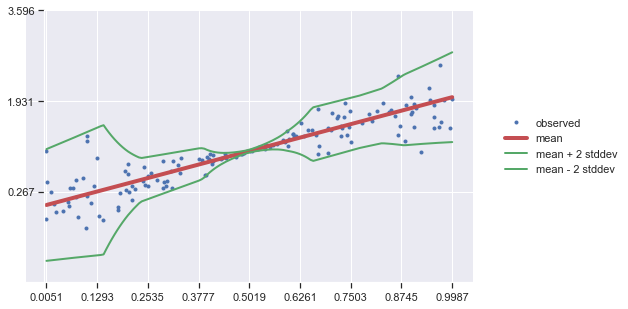

In [26]:
plot_save_fig(yhat_flex,x_tst_syn_ds2,x_syn_ds2, y_syn_ds2,"Fig3")

Now, we can see that our confidence shows a non-monotonic profile.

# A Non-Linear DataSet

In [27]:
def syn_dataset3(n=150, n_tst=150,beta=2):
    # to allow for reproducibility 
    np.random.seed(43)
    # We're making the picking the input features randomly.
    x = np.random.rand(n)
    
    #Let's make the errors heterosckedastic(non-monotonic)
    eps = ((x-0.5)**2.)*np.random.randn(n)
    
    y = (x**5)+eps
    x = x[:, np.newaxis]
    
    # we're making the test inputs to be deterministic, probably different from the 
    # training input features
    x_tst = np.linspace(np.min(x),np.max(x), num=n_tst).astype(np.float32)
    x_tst = x_tst[:, np.newaxis]
    return y, x, x_tst

y_syn_ds3, x_syn_ds3, x_tst_syn_ds3 = syn_dataset3()

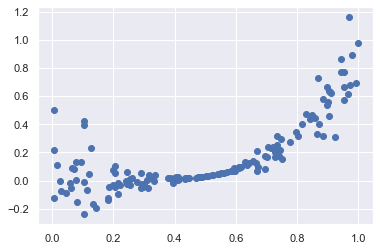

In [28]:
plt.scatter(x_syn_ds3,y_syn_ds3)
plt.show()

In [29]:
model_flex_sd.fit(x_syn_ds3, y_syn_ds3, epochs=1000, verbose=False);
yhat_flex_3= model_flex_sd(x_tst_syn_ds3)

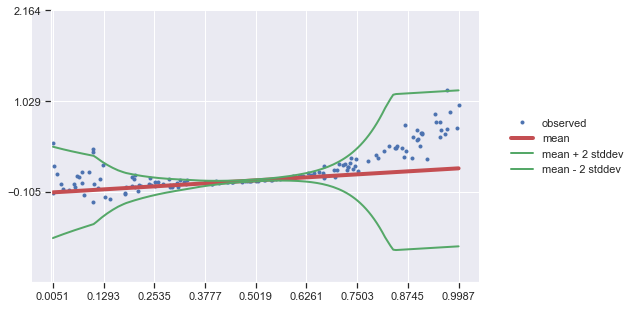

In [30]:
plot_save_fig(yhat_flex_3,x_tst_syn_ds3,x_syn_ds3, y_syn_ds3,"Fig4")

Our model looks very strange... This happens because we've allowed for a non-monotonic std-dev, but still assumed a linear mean.

Let's change our model.

In [31]:
inputs = tf.keras.layers.Input(shape=(1,)) 

hidden1_sd = tf.keras.layers.Dense(30,activation="relu")(inputs)
hidden1_sd = tf.keras.layers.Dense(20,activation="relu")(hidden1_sd)
hidden2_sd = tf.keras.layers.Dense(20,activation="relu")(hidden1_sd)
out2 = tf.keras.layers.Dense(1)(hidden2_sd)

hidden1_m = tf.keras.layers.Dense(30,activation="relu")(inputs)
hidden1_m = tf.keras.layers.Dense(20,activation="relu")(hidden1_m)
hidden2_m = tf.keras.layers.Dense(20,activation="relu")(hidden1_m)
out1 = tf.keras.layers.Dense(1)(hidden2_m)

params = tf.keras.layers.Concatenate()([out1,out2]) 
dist = tfp.layers.DistributionLambda(
    lambda t: tfd.Normal(loc=t[:,:1],scale=1e-5+tf.math.softplus(t[:, 1:])
                        )
    )(params) 

model_flex_both = tf.keras.Model(inputs=inputs, outputs=dist)


In [32]:
model_flex_both.compile(tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model_flex_both.fit(x_syn_ds3, y_syn_ds3, epochs=1000, verbose=False);
yhat_flex_3= model_flex_both(x_tst_syn_ds3)

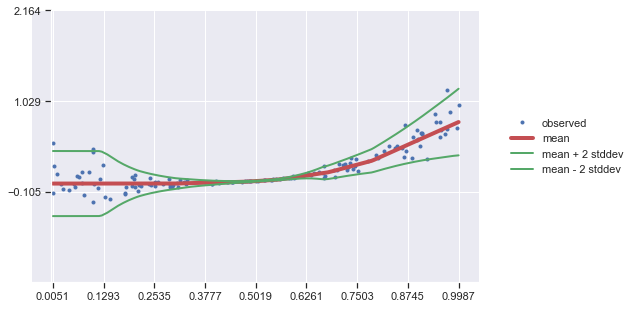

In [33]:
plot_save_fig(yhat_flex_3,x_tst_syn_ds3,x_syn_ds3, y_syn_ds3,"Fig5")

Now, it looks much better.